<a href="https://colab.research.google.com/github/m607stars/Reading-WeeBit-with-LSTMs-CNNs/blob/main/WeeBit_CNN_LSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installs

Note: DO NOT forget to change the path for saving models

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install torchviz

In [45]:
import numpy as np
import pandas as pd
import os
import torch
from nltk.tokenize import word_tokenize
from torchtext import vocab
import random
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print("Seeding done")
seed_everything(42)

Seeding done


In [48]:
VECTOR_PATH = '/content/drive/MyDrive/Readability_Research_Paper/'
VECTOR_NAME = 'glove.6B.300d.txt'

TEXT_LENGTH = 187
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 200
BATCH_SIZE=16

embeddings = vocab.Vectors(VECTOR_NAME,VECTOR_PATH)

In [49]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [50]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Readability_Research_Paper/train.csv')
train_dataset['readability'] = train_dataset['readability'].apply(lambda x: x-2)
train_dataset.head()

,text,readability
0,they sent me a salwar kameezpeacockblueand ano...,4
1,the chart shows each planet and its number of ...,0
2,this revision bite will help you understand wh...,4
3,what are powers and roots find out how they work,3
4,the wright brothers flew the first airplane ne...,0


In [51]:
test_dataset = pd.read_csv('/content/drive/MyDrive/Readability_Research_Paper/test.csv')
test_dataset['readability'] = test_dataset['readability'].apply(lambda x: x-2)
test_dataset.head()

,text,readability
0,to understand a work of art or a beautiful obj...,4
1,perhaps the most important of these is the use...,4
2,q what is a tornados favorite game a twister,0
3,the final thing to remember is there are lots ...,4
4,3d shapes have 3dimensions length width and de...,3


# Data pre-processing and DataLoaders

In [52]:
def get_word_to_index(texts):
    word_to_index = {
        '<PAD>':0,
        '<START>':1,
        '<END>':2,
    }
    ind = 3
    for text in texts:
        words = word_tokenize(text)
        for word in words:
            if word not in word_to_index.keys():
                word_to_index[word] = ind
                ind += 1
                
    return word_to_index   

word_to_index_dict = get_word_to_index(train_dataset['text'])
VOCABULARY_SIZE = len(word_to_index_dict.keys())
print(VOCABULARY_SIZE)

21072


In [53]:
def get_tensor_from_text(text):
    word_list = []
    words = word_tokenize(text)
    for word in words:
        word_list.append(word_to_index_dict[word])
    if len(word_list) > TEXT_LENGTH:
        word_list = word_list[:TEXT_LENGTH]
    else:
        word_list.extend([0]*(TEXT_LENGTH-len(word_list)))
    
    tensor_list = torch.tensor(word_list, device=device, dtype=torch.long)
    return tensor_list

In [54]:
class WeebitDataset(torch.utils.data.Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    
    def __getitem__(self,index): 
        text = self.dataset['text'].iloc[index]
        y = torch.tensor(self.dataset['readability'].iloc[index],dtype=torch.float,device=device)
        x = get_tensor_from_text(text)
        return x,y
    
    def __len__(self):
        return len(self.dataset)

In [55]:
def create_embedding_matrix(embeddings,vocabulary_size):  
    embedding_matrix = np.random.rand(vocabulary_size,EMBEDDING_SIZE)
    for string,index in word_to_index_dict.items():
        if not  all(x == 0 for x in embeddings[string].tolist()):
            embedding_matrix[index] = embeddings[string] 
    return embedding_matrix

In [56]:
embedding_matrix = create_embedding_matrix(embeddings,VOCABULARY_SIZE)

# Model and Training 

## Done

In [ ]:
# Mayank

class ReadabilityModel_LSTM(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.lstm_layer = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers, dropout=self.dropout_probability,
                                        batch_first=True, bidirectional=True)
        self.linear_layer_1 = torch.nn.Linear(hidden_size,128)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_layer_2 = torch.nn.Linear(128,5)

    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,187,300
        lstm_output, (ht, ct) = self.lstm_layer(x)
        #Shape of lstm_output_1 is 16,50,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        linear_output_1 = self.linear_layer_1(ht[-1])
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)
        linear_output_2 = self.linear_layer_2(linear_output_1)
        output = linear_output_2
        return output

In [ ]:
# Mayank

class ReadabilityModel_1_CNN_LSTM(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=3,stride=1)
        self.lstm_layer = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers, dropout=self.dropout_probability,
                                        batch_first=True, bidirectional=True)
        self.linear_layer_1 = torch.nn.Linear(hidden_size,128)
        self.linear_layer_2 = torch.nn.Linear(128,64)
        self.linear_layer_3 = torch.nn.Linear(64,16)
        self.linear_layer_4 = torch.nn.Linear(16,5)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU() 

    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,187,300
        x = x.permute(0,2,1) #shape of x is 16,300,187
        conv_output_1 = self.conv_layer_1(x) #shape of conv_output_1 is 16,300,185
        conv_output = conv_output_1.permute(0,2,1)  #shape of conv_output_2 is 16,61,300
        lstm_output, (ht, ct) = self.lstm_layer(conv_output)
        #Shape of lstm_output_1 is 16,300,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        linear_output_1 = self.linear_layer_1(ht[-1])
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)

        linear_output_2 = self.linear_layer_2(linear_output_1)
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)

        linear_output_3 = self.linear_layer_3(linear_output_2)
        linear_output_3 = self.leaky_relu(linear_output_3)
        linear_output_3 = self.dropout_layer(linear_output_3)

        linear_output_4 = self.linear_layer_4(linear_output_3)
        output = linear_output_4
        return output

In [ ]:
# Mayank

class ReadabilityModel_2_CNN_LSTM(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=5,stride=3)
        self.lstm_layer = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers, dropout=self.dropout_probability,
                                        batch_first=True, bidirectional=True)
        self.linear_layer_1 = torch.nn.Linear(hidden_size,128)
        self.linear_layer_2 = torch.nn.Linear(128,64)
        self.linear_layer_3 = torch.nn.Linear(64,16)
        self.linear_layer_4 = torch.nn.Linear(16,5)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU() 

    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,187,300
        x = x.permute(0,2,1) #shape of x is 16,300,187
        conv_output_1 = self.conv_layer_1(x) #shape of conv_output_1 is 16,300,185
        conv_output_2 = self.conv_layer_2(conv_output_1) #shape of conv_output_2 is 16,300,61
        conv_output = conv_output_1.permute(0,2,1)  #shape of conv_output_2 is 16,61,300
        lstm_output, (ht, ct) = self.lstm_layer(conv_output)
        #Shape of lstm_output_1 is 16,300,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        linear_output_1 = self.linear_layer_1(ht[-1])
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)

        linear_output_2 = self.linear_layer_2(linear_output_1)
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)

        linear_output_3 = self.linear_layer_3(linear_output_2)
        linear_output_3 = self.leaky_relu(linear_output_3)
        linear_output_3 = self.dropout_layer(linear_output_3)

        linear_output_4 = self.linear_layer_4(linear_output_3)
        output = linear_output_4
        return output

## Current

In [72]:
# Mayank

class ReadabilityModel_3_CNNs(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=5,stride=3)
        self.conv_layer_3 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=7,stride=9)
        self.conv_linear_layer_1 = torch.nn.Linear(185,128)
        self.conv_linear_layer_2 = torch.nn.Linear(61,128)
        self.conv_linear_layer_3 = torch.nn.Linear(21,128)

        self.linear_layer_1 = torch.nn.Linear(900,256)
        self.linear_layer_2 = torch.nn.Linear(256,64)
        self.linear_layer_3 = torch.nn.Linear(64,8)
        self.linear_layer_4 = torch.nn.Linear(8,1)
        self.linear_layer_5 = torch.nn.Linear(128,32)
        self.linear_layer_6 = torch.nn.Linear(32,5)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU() 

    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,187,300
        x = x.permute(0,2,1) #shape of x is 16,300,187
        conv_output_1 = self.conv_layer_1(x) #shape of conv_output_1 is 16,300,185
        conv_output_2 = self.conv_layer_2(x) #shape of conv_output_2 is 16,300,61
        conv_output_3 = self.conv_layer_3(x) #shape of conv_output_3 is 16,300,21
        conv_output_linear_1 = self.conv_linear_layer_1(conv_output_1)  #Shape is 16,300,128
        conv_output_linear_2 = self.conv_linear_layer_2(conv_output_2)  #Shape is 16,300,128
        conv_output_linear_3 = self.conv_linear_layer_3(conv_output_3)  #Shape is 16,300,128
        conv_output = torch.cat([conv_output_linear_1,conv_output_linear_2,conv_output_linear_3],
                                dim=1)  #Shape is 16,900,128
        conv_output = conv_output.permute(0,2,1) #Shape is 16,128,900

        linear_output_1 = self.linear_layer_1(conv_output)
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)

        linear_output_2 = self.linear_layer_2(linear_output_1)
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)

        linear_output_3 = self.linear_layer_3(linear_output_2)
        linear_output_3 = self.leaky_relu(linear_output_3)
        linear_output_3 = self.dropout_layer(linear_output_3)

        linear_output_4 = self.linear_layer_4(linear_output_3)
        linear_output_4 = self.leaky_relu(linear_output_4)
        linear_output_4 = self.dropout_layer(linear_output_4)
        linear_output_4 = linear_output_4.squeeze(2)

        linear_output_5 = self.linear_layer_5(linear_output_4)
        linear_output_5 = self.leaky_relu(linear_output_5)
        linear_output_5 = self.dropout_layer(linear_output_5)

        linear_output_6 = self.linear_layer_6(linear_output_5)
        output = linear_output_6
        return output

## To be done

In [ ]:
# Mayank

class ReadabilityModel_CNN_LSTM_Attention(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=5,stride=3)
        self.lstm_layer_1 = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers, dropout=self.dropout_probability,
                                        batch_first=True, bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size, hidden_size*2)
        self.linear_layer_1 = torch.nn.Linear(512,256)
        self.linear_layer_2 = torch.nn.Linear(256,64)
        self.linear_layer_3 = torch.nn.Linear(64,16)
        self.linear_layer_4 = torch.nn.Linear(16,1)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU()       
        self.output_layer = torch.nn.Linear(50,5)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,187,300
        conv_output_1 = self.conv_layer_1(x) #shape of conv_output_1 is 16,100,300
        conv_output_2 = self.conv_layer_2(conv_output_1) #shape of conv_output_2 is 16,50,300
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(conv_output_2)
        #Shape of lstm_output_1 is 16,50,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        attention_output = self.attention_layer(ht1[-1])
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,50,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,50,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,50,512
#         final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,50,1024
        linear_output_1 = self.linear_layer_1(word_context)
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)

        linear_output_2 = self.linear_layer_2(linear_output_1)
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)

        linear_output_3 = self.linear_layer_3(linear_output_2)
        linear_output_3 = self.leaky_relu(linear_output_3)
        linear_output_3 = self.dropout_layer(linear_output_3)

        linear_output_4 = self.linear_layer_4(linear_output_3)
        linear_output_4 = linear_output_4.squeeze(2)
        output = self.output_layer(linear_output_4)
        return output

In [ ]:
# talha

class ReadabilityModel_LSTM_Attention(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.lstm_layer_1 = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers, dropout=self.dropout_probability,
                                        batch_first=True, bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size, hidden_size*2)
        self.linear_layer_1 = torch.nn.Linear(512,256)
        self.linear_layer_2 = torch.nn.Linear(256,64)
        self.linear_layer_3 = torch.nn.Linear(64,16)
        self.linear_layer_4 = torch.nn.Linear(16,1)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.output_layer = torch.nn.Linear(187,5)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(x)
        #Shape of lstm_output_1 is 16,200,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        attention_output = self.attention_layer(ht1[-1])
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,187,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,50,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,50,512
#         final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,50,1024
        linear_output_1 = self.linear_layer_1(word_context)
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)
        linear_output_2 = self.linear_layer_2(linear_output_1)
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)
        linear_output_3 = self.linear_layer_3(linear_output_2)
        linear_output_3 = self.leaky_relu(linear_output_3)
        linear_output_3 = self.dropout_layer(linear_output_3)
        linear_output_4 = self.linear_layer_4(linear_output_3)
        linear_output_4 = self.leaky_relu(linear_output_4)
        linear_output_4 = self.dropout_layer(linear_output_4)
        linear_output_4 = linear_output_4.squeeze(2)
        output = self.output_layer(linear_output_4)
        return output

# Average Validation Loss:0.7848541466199805
# Lowest Validation loss is 0.7264222720253899 at fold 3

In [ ]:
# Talha

class ReadabilityModel_CNN_LSTM_Attention_CNN(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers, batch_size):
        super().__init__()
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=200,out_channels=100,kernel_size=1,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=100,out_channels=50,kernel_size=1,stride=1)
        self.lstm_layer_1 = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size, hidden_size*2)
        self.linear_layer_1 = torch.nn.Linear(512,256)
        self.linear_layer_2 = torch.nn.Linear(256,64)
        self.linear_layer_3 = torch.nn.Linear(64,16)
        self.linear_layer_4 = torch.nn.Linear(16,1)       
        self.output_layer = torch.nn.Linear(50,1)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        conv_output_1 = self.conv_layer_1(x) #shape of conv_output_1 is 16,100,300
        conv_output_2 = self.conv_layer_2(conv_output_1) #shape of conv_output_2 is 16,50,300
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(conv_output_2)
        #Shape of lstm_output_1 is 16,50,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        attention_output = self.attention_layer(ht1[-1])
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,50,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,50,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,50,512
#         final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,50,1024
        linear_output_1 = self.linear_layer_1(word_context)
        linear_output_2 = self.linear_layer_2(linear_output_1)
        linear_output_3 = self.linear_layer_3(linear_output_2)
        linear_output_4 = self.linear_layer_4(linear_output_3)
        linear_output_4 = linear_output_4.squeeze(2)
        output = self.output_layer(linear_output_4)
        return output

# Average Validation Loss:0.7848541466199805
# Lowest Validation loss is 0.7264222720253899 at fold 3

In [ ]:
# Mayank

class ReadabilityModel_CNN_LSTM_Attention_LSTM(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers, batch_size):
        super().__init__()
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=200,out_channels=100,kernel_size=1,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=100,out_channels=50,kernel_size=1,stride=1)
        self.lstm_layer_1 = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size, hidden_size*2)
        self.linear_layer_embedding_context = torch.nn.Linear(1024,512)
        self.lstm_layer_2 = torch.nn.LSTM(512, hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, bidirectional=True)
        self.linear_layer_1 = torch.nn.Linear(256,128)
        self.linear_layer_2 = torch.nn.Linear(128,32)
        self.linear_layer_3 = torch.nn.Linear(32,8)
        self.linear_layer_4 = torch.nn.Linear(8,1)
        self.dropout_layer = torch.nn.Dropout(p=0.1)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        conv_output_1 = self.conv_layer_1(x) #shape of conv_output_1 is 16,100,300
        conv_output_1 = self.dropout_layer(conv_output_1)
        conv_output_2 = self.conv_layer_2(conv_output_1) #shape of conv_output_2 is 16,50,300
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(conv_output_2)
        #Shape of lstm_output_1 is 16,50,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        attention_output = self.attention_layer(ht1[-1])
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,50,512
        attention_context = self.dropout_layer(attention_context)
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,50,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,50,512
        final_context_words = word_context*lstm_output_1  #Shape is 16,50,512
        lstm_output_2, (ht2, ct2) = self.lstm_layer_2(final_context_words)
        #Shape of lstm_output_2 is 16,50,1024 
        #Shape of ht2 is 6,16,256 
        #Shape of ct2 is 6,16,256
        linear_output_1 = self.linear_layer_1(ht2[-1])     #Shape is 16,128
        linear_output_2 = self.linear_layer_2(linear_output_1)   #Shape is 16,32
        linear_output_2 = self.dropout_layer(linear_output_2)
        linear_output_3 = self.linear_layer_3(linear_output_2)   #Shape is 16,8
        linear_output_4 = self.linear_layer_4(linear_output_3)   #Shape is 16,1
        output = linear_output_4   #Shape of output is 16,1
        return output
    
# Average Validation Loss:0.9133829620398682 
# Lowest Validation Loss: 0.8187914316807785 at fold 0

In [ ]:
# talha

class ReadabilityModel_LSTM_Attention_CNN(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers, batch_size, training):
        super().__init__()
        if training:
            self.dropout_prob = 0.2
        else:
            self.dropout_prop = 0.0
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.lstm_layer_1 = torch.nn.LSTM(embedding_matrix.shape[1], hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, dropout=self.dropout_prob,
                                        bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size,hidden_size*2)
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=5,stride=3)
        self.conv_layer_3 = torch.nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=11,stride=9)
        self.conv_linear_layer_1 = torch.nn.Linear(198,128)
        self.conv_linear_layer_2 = torch.nn.Linear(66,128)
        self.conv_linear_layer_3 = torch.nn.Linear(22,128)
        self.conv_output_linear_layer_1 = torch.nn.Linear(3072,1024)
        self.conv_output_linear_layer_2 = torch.nn.Linear(1024,256)
        self.conv_output_linear_layer_3 = torch.nn.Linear(256,32)
        self.conv_output_linear_layer_4 = torch.nn.Linear(32,8)
        self.tanh = torch.nn.Tanh()
        self.conv_output_linear_layer_5 = torch.nn.Linear(8,1)
        self.linear_layer_1 = torch.nn.Linear(128,64)
        self.linear_layer_2 = torch.nn.Linear(64,1)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(x)
        #Shape of lstm_output_1 is 16,200,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        #Shape of ht1[-1] is 16,256
        attention_output = self.attention_layer(ht1[-1]) #Shape of is 16,512
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,200,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,200,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,200,512
        final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,200,1024
        final_context_words = final_context_words.permute(0,2,1)
        conv_output_1 = self.conv_layer_1(final_context_words)       #Shape is 16,1024,198
        conv_output_2 = self.conv_layer_2(final_context_words)       #Shape is 16,1024,66
        conv_output_3 = self.conv_layer_3(final_context_words)       #Shape is 16,1024,22
        conv_output_linear_1 = self.conv_linear_layer_1(conv_output_1)  #Shape is 16,1024,128
        conv_output_linear_2 = self.conv_linear_layer_2(conv_output_2)  #Shape is 16,1024,128
        conv_output_linear_3 = self.conv_linear_layer_3(conv_output_3)  #Shape is 16,1024,128
        conv_output = torch.cat([conv_output_linear_1,conv_output_linear_2,conv_output_linear_3],
                                dim=1)  #Shape is 16,3072,128
        conv_output = conv_output.permute(0,2,1) #Shape is 16,128,3072
        conv_linear_output_1 = self.conv_output_linear_layer_1(conv_output)  #Shape is 16,128,1024
        conv_linear_output_2 = self.conv_output_linear_layer_2(conv_linear_output_1)#Shape is 16,128,256
        conv_linear_output_2 = self.tanh(conv_linear_output_2)
        conv_linear_output_3 = self.conv_output_linear_layer_3(conv_linear_output_2)
        conv_linear_output_4 = self.conv_output_linear_layer_4(conv_linear_output_3)
        conv_linear_output_4 = self.tanh(conv_linear_output_4)
        conv_linear_output_5 = self.conv_output_linear_layer_5(conv_linear_output_4)
        conv_linear_output_5 = conv_linear_output_5.squeeze(2)
        linear_output_1 = self.linear_layer_1(conv_linear_output_5)  #Shape is 16,64
        linear_output_1 = self.tanh(linear_output_1)
        linear_output_2 = self.linear_layer_2(linear_output_1)  #Shape is 16,1
        output = linear_output_2   #Shape of output is 16,1
        return output

# Average Validation Loss:0.6796757201937529
# Lowest validation loss is 0.6500918945654444 at fold 3

In [ ]:
# talha

class ReadabilityModel_LSTM_Attention_CNN_GRU(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers, batch_size, training):
        super().__init__()
        if training:
            self.dropout_prob = 0.2
        else:
            self.dropout_prop = 0.0
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.lstm_layer_1 = torch.nn.LSTM(embedding_matrix.shape[1], hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, dropout=self.dropout_prob,
                                        bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size,hidden_size*2)
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=5,stride=3)
        self.conv_layer_3 = torch.nn.Conv1d(in_channels=1024,out_channels=1024,kernel_size=11,stride=9)
        self.conv_linear_layer_1 = torch.nn.Linear(198,128)
        self.conv_linear_layer_2 = torch.nn.Linear(66,128)
        self.conv_linear_layer_3 = torch.nn.Linear(22,128)
        self.conv_output_linear_layer_1 = torch.nn.Linear(3072,1024)
        self.conv_output_linear_layer_2 = torch.nn.Linear(1024,256)
        self.gru_layer = torch.nn.GRU(256,hidden_size,num_layers=num_of_layers,batch_first=True,
                                     dropout=self.dropout_prob)
        self.linear_layer_1 = torch.nn.Linear(256,64)
        self.linear_layer_2 = torch.nn.Linear(64,8)
        self.linear_layer_3 = torch.nn.Linear(8,1)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(x)
        #Shape of lstm_output_1 is 16,200,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        #Shape of ht1[-1] is 16,256
        attention_output = self.attention_layer(ht1[-1]) #Shape of is 16,512
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,200,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,200,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,200,512
        final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,200,1024
        final_context_words = final_context_words.permute(0,2,1)
        conv_output_1 = self.conv_layer_1(final_context_words)       #Shape is 16,1024,198
        conv_output_2 = self.conv_layer_2(final_context_words)       #Shape is 16,1024,66
        conv_output_3 = self.conv_layer_3(final_context_words)       #Shape is 16,1024,22
        conv_output_linear_1 = self.conv_linear_layer_1(conv_output_1)  #Shape is 16,1024,128
        conv_output_linear_2 = self.conv_linear_layer_2(conv_output_2)  #Shape is 16,1024,128
        conv_output_linear_3 = self.conv_linear_layer_3(conv_output_3)  #Shape is 16,1024,128
        conv_output = torch.cat([conv_output_linear_1,conv_output_linear_2,conv_output_linear_3],
                                dim=1)  #Shape is 16,3072,128
        conv_output = conv_output.permute(0,2,1) #Shape is 16,128,3072
        conv_linear_output_1 = self.conv_output_linear_layer_1(conv_output)  #Shape is 16,128,1024
        conv_linear_output_2 = self.conv_output_linear_layer_2(conv_linear_output_1)#Shape is 16,128,256
        gru_output , ht = self.gru_layer(conv_linear_output_2)
        #Shape of ht is 16,256
        linear_output_1 = self.linear_layer_1(ht[-1])  #Shape is 16,64
        linear_output_2 = self.linear_layer_2(linear_output_1)  #Shape is 16,8
        linear_output_3 = self.linear_layer_3(linear_output_2)  #Shape is 16,1
        output = linear_output_3   #Shape of output is 16,1
        return output

# Average Validation Loss:1.0334918799897828
# Lowest avalidation loss is 1.013418031971577 at fold 3

In [ ]:
# mayank

class CommonLitCNNLSTMAttention_EnsembleModel(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_layers, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
                
        self.embedding_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embedding_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix,
                                                                      dtype=torch.float32,
                                                                      device=device))
        self.embedding_layer.weight.requires_grad = False
        
        # Block 1
        self.lstm_layer_1 = torch.nn.LSTM(embedding_matrix.shape[1],hidden_size,
                                          batch_first = True,num_layers = self.num_layers,
                                          bidirectional=True)        
        self.attention_linear_layer = torch.nn.Linear(hidden_size,2*hidden_size)
        self.lstm_layer_2 = torch.nn.LSTM(4*hidden_size,hidden_size,
                                          batch_first=True,num_layers = self.num_layers,
                                          bidirectional=True)
        
        # Block 2
        self.lstm_layer_3 = torch.nn.LSTM(embedding_matrix.shape[1],hidden_size,
                                    batch_first = True,num_layers = self.num_layers,
                                    bidirectional=True)        
        self.conv1 = torch.nn.Conv1d(in_channels = 2*hidden_size, out_channels=hidden_size,
                               kernel_size=3,stride=1)
        self.conv2 = torch.nn.Conv1d(in_channels = 2*hidden_size, out_channels=hidden_size,
                               kernel_size=5,stride=1)
        self.conv3 = torch.nn.Conv1d(in_channels = 2*hidden_size, out_channels=hidden_size,
                               kernel_size=7,stride=1)
        self.low_lstm = torch.nn.LSTM(hidden_size,hidden_size,
                                batch_first = True,num_layers = self.num_layers,
                                bidirectional=True)
        self.med_lstm = torch.nn.LSTM(hidden_size,hidden_size,
                                batch_first = True,num_layers = self.num_layers,
                                bidirectional=True)
        self.high_lstm = torch.nn.LSTM(hidden_size,hidden_size,
                                 batch_first = True,num_layers = self.num_layers,
                                 bidirectional=True)
        self.lstm_features_concat_layer = torch.nn.Linear(3*hidden_size,hidden_size)

        #Combining Block 1 and 2
        self.output_linear_1 = torch.nn.Linear(2*hidden_size,hidden_size)
        self.output_linear_2 = torch.nn.Linear(hidden_size,hidden_size // 2)
        self.output_linear_3 = torch.nn.Linear(hidden_size// 2,1)
    
    
    def forward(self,input_text):
        self.embeddings = self.embedding_layer(input_text.long().to(device))
        self.embeddings = self.embeddings.permute(0, 2, 1)   # convert to [batch, channels, time]
        self.embeddings = torch.nn.functional.dropout2d(self.embeddings, 0.2, training=self.training)
        self.embeddings = self.embeddings.permute(0, 2, 1)
        
        #Block 1
        lstm_output_1,(hidden_state_1,cell_state) = self.lstm_layer_1(self.embeddings)
        final_state_1 = hidden_state_1[-1,:,:]
        attention_linear_output = self.attention_linear_layer(final_state_1)
        attention_linear_output = attention_linear_output.unsqueeze(1)
        attention_multiplied_context = lstm_output_1 * attention_linear_output
        softmax_attention = torch.nn.functional.softmax(attention_multiplied_context,dim=1)
        global_context = softmax_attention * lstm_output_1
        final_context_words = torch.cat([global_context,lstm_output_1],dim=2) # 64,seq_len,4*hidden_size
        lstm_output_2, (hidden_state_2,cell_state_2) = self.lstm_layer_2(final_context_words)
        final_state_2 = hidden_state_2[-1,:,:]

        #Block 2
        lstm_output_3,(hidden_state_3,cell_state_3) = self.lstm_layer_3(self.embeddings)
        lstm_output_3 = lstm_output_3.permute(0,2,1)
        
        conv_1_output = self.conv1(lstm_output_3)
        conv_1_output = conv_1_output.permute(0,2,1) 

        conv_2_output = self.conv2(lstm_output_3)
        conv_2_output = conv_2_output.permute(0,2,1)
        
        conv_3_output = self.conv3(lstm_output_3)
        conv_3_output = conv_3_output.permute(0,2,1)

        low_lstm_output,(hidden_state_low,cell_state_low) = self.low_lstm(conv_1_output)
        med_lstm_output,(hidden_state_med,cell_state_med) = self.med_lstm(conv_2_output)
        high_lstm_output,(hidden_state_high,cell_state_high) = self.high_lstm(conv_3_output)
        concat_features = torch.cat([hidden_state_low[-1,:,:],hidden_state_med[-1,:,:],hidden_state_high[-1,:,:]],dim=1)
        lstm_linear_concat_output = self.lstm_features_concat_layer(concat_features)

        #Combining BLock 1 and 2 
        short_long_context_features = torch.cat([final_state_2,lstm_linear_concat_output],dim=1)
        linear_output_1 = self.output_linear_1(short_long_context_features)
        linear_output_2 = self.output_linear_2(linear_output_1)
        linear_output_3 = self.output_linear_3(linear_output_2)

        return linear_output_3

In [ ]:
# mayank

class ReadabilityModel_parallel_LSTM_Attention_and_CNN(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers, batch_size, training):
        super().__init__()
        if training:
            self.dropout_prob = 0.2
        else:
            self.dropout_prop = 0.0
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        
        # Block 1 - Lstm layer block
        self.lstm_layer_1 = torch.nn.LSTM(embedding_matrix.shape[1], hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, dropout=self.dropout_prob,
                                        bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size,hidden_size*2)
        self.lstm_linear_layer = torch.nn.Linear(1024,256)
        
        # Block 2 - Conv layer block
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=5,stride=3)
        self.conv_layer_3 = torch.nn.Conv1d(in_channels=300,out_channels=300,kernel_size=11,stride=9)
        self.conv_linear_layer_1 = torch.nn.Linear(198,128)
        self.conv_linear_layer_2 = torch.nn.Linear(66,128)
        self.conv_linear_layer_3 = torch.nn.Linear(22,128)
        self.conv_output_linear_layer = torch.nn.Linear(900,256)
        
        # Combining both the blocks 
        self.linear_layer_1 = torch.nn.Linear(256,64)
        self.linear_layer_2 = torch.nn.Linear(64,8)
        self.linear_layer_3 = torch.nn.Linear(8,1)
        self.linear_layer_4 = torch.nn.Linear(328,128)
        self.linear_layer_5 = torch.nn.Linear(128,32)
        self.linear_layer_6 = torch.nn.Linear(32,8)
        self.linear_layer_7 = torch.nn.Linear(8,1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_prob)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        
        # Block 1 - Lstm layer block
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(x)
        #Shape of lstm_output_1 is 16,200,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        #Shape of ht1[-1] is 16,256
        attention_output = self.attention_layer(ht1[-1]) #Shape of is 16,512
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,200,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,200,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,200,512
        final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,200,1024
        block_1_output = self.lstm_linear_layer(final_context_words)  #Shape is 16,200,256
        
        # Block 2 - Conv layer block
        x_permuted = x.permute(0,2,1)   #Shape is 16,300,200
        conv_output_1 = self.conv_layer_1(x_permuted)       #Shape is 16,300,198
        conv_output_2 = self.conv_layer_2(x_permuted)       #Shape is 16,300,66
        conv_output_3 = self.conv_layer_3(x_permuted)       #Shape is 16,300,22
        conv_output_linear_1 = self.conv_linear_layer_1(conv_output_1)  #Shape is 16,300,128
        conv_output_linear_2 = self.conv_linear_layer_2(conv_output_2)  #Shape is 16,300,128
        conv_output_linear_3 = self.conv_linear_layer_3(conv_output_3)  #Shape is 16,300,128
        conv_output = torch.cat([conv_output_linear_1,conv_output_linear_2,conv_output_linear_3],
                                dim=1)  #Shape is 16,900,128
        conv_output = conv_output.permute(0,2,1) #Shape is 16,128,900
        block_2_output = self.conv_output_linear_layer(conv_output)  #Shape is 16,128,256
        
        # Combining block 1 & 2
        concatenated_output = torch.cat([block_1_output,block_2_output],dim=1)  #Shape is 16,328,256
        linear_output_1 = self.linear_layer_1(concatenated_output)  #Shape is 16,328,64
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)
        
        linear_output_2 = self.linear_layer_2(linear_output_1)  #Shape is 16,328,8
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)
        
        linear_output_3 = self.linear_layer_3(linear_output_2)  #Shape is 16,328,1
        linear_output_3 = self.dropout_layer(linear_output_3)
        linear_output_3 = linear_output_3.squeeze(2)            #Shape is 16,328
        
        linear_output_4 = self.linear_layer_4(linear_output_3)  #Shape is 16,128
        linear_output_4 = self.leaky_relu(linear_output_4)
        linear_output_4 = self.dropout_layer(linear_output_4)
        
        linear_output_5 = self.linear_layer_5(linear_output_4)  #Shape is 16,32
        linear_output_5 = self.leaky_relu(linear_output_5)        
        linear_output_5 = self.dropout_layer(linear_output_5)
        
        linear_output_6 = self.linear_layer_6(linear_output_5)  #Shape is 16,8
        linear_output_6 = self.dropout_layer(linear_output_6)

        linear_output_7 = self.linear_layer_7(linear_output_6)  #Shape is 16,1
        output = linear_output_7
        return output

# Average Validation Loss:
# Lowest validation loss is  at fold 3

In [ ]:
# talha

class ReadabilityModel_parallel_LSTM_Attention_and_LSTM_CNN(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers, batch_size, training):
        super().__init__()
        if training:
            self.dropout_prob = 0.2
        else:
            self.dropout_prop = 0.0
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        
        # Block 1 - Lstm layer block
        self.lstm_layer_1 = torch.nn.LSTM(embedding_matrix.shape[1], hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, dropout=self.dropout_prob,
                                        bidirectional=True)
        self.attention_layer = torch.nn.Linear(hidden_size,hidden_size*2)
        self.lstm_linear_layer = torch.nn.Linear(1024,256)
        
        # Block 2 - Conv layer block
        self.lstm_layer_2 = torch.nn.LSTM(embedding_matrix.shape[1], hidden_size,
                                        num_layers=num_of_layers,
                                        batch_first=True, dropout=self.dropout_prob,
                                        bidirectional=True)
        self.conv_layer_1 = torch.nn.Conv1d(in_channels=512,out_channels=512,kernel_size=3,stride=1)
        self.conv_layer_2 = torch.nn.Conv1d(in_channels=512,out_channels=512,kernel_size=5,stride=3)
        self.conv_layer_3 = torch.nn.Conv1d(in_channels=512,out_channels=512,kernel_size=11,stride=9)
        self.conv_linear_layer_1 = torch.nn.Linear(198,128)
        self.conv_linear_layer_2 = torch.nn.Linear(66,128)
        self.conv_linear_layer_3 = torch.nn.Linear(22,128)
        self.conv_output_linear_layer = torch.nn.Linear(1536,256)
        
        # Combining both the blocks 
        self.linear_layer_1 = torch.nn.Linear(256,64)
        self.linear_layer_2 = torch.nn.Linear(64,8)
        self.linear_layer_3 = torch.nn.Linear(8,1)
        self.linear_layer_4 = torch.nn.Linear(328,128)
        self.linear_layer_5 = torch.nn.Linear(128,32)
        self.linear_layer_6 = torch.nn.Linear(32,8)
        self.linear_layer_7 = torch.nn.Linear(8,1)
        self.tanh = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_prob)
    
    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        
        # Block 1 - Lstm layer block
        lstm_output_1, (ht1, ct1) = self.lstm_layer_1(x)
        #Shape of lstm_output_1 is 16,200,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        #Shape of ht1[-1] is 16,256
        attention_output = self.attention_layer(ht1[-1]) #Shape of is 16,512
        attention_output = attention_output.unsqueeze(1) #Shape is 16,1,512
        attention_context = lstm_output_1 * attention_output #Shape is 16,200,512
        softmax_attention = torch.nn.functional.softmax(attention_context,dim=1) #Shape is 16,200,512
        word_context = softmax_attention * lstm_output_1  #Shape is 16,200,512
        final_context_words = torch.cat([word_context,lstm_output_1],dim=2)  #Shape is 16,200,1024
        block_1_output = self.lstm_linear_layer(final_context_words)  #Shape is 16,200,256
        
        # Block 2 - Conv layer block
        lstm_output_2, (ht2, ct2) = self.lstm_layer_2(x)
        #Shape of lstm_output_2 is 16,200,512 
        #Shape of ht2 is 6,16,256 
        #Shape of ct2 is 6,16,256
        #Shape of ht2[-1] is 16,256
        lstm_output_2_permuted = lstm_output_2.permute(0,2,1)   #Shape is 16,512,200
        conv_output_1 = self.conv_layer_1(lstm_output_2_permuted)       #Shape is 16,512,198
        conv_output_2 = self.conv_layer_2(lstm_output_2_permuted)       #Shape is 16,512,66
        conv_output_3 = self.conv_layer_3(lstm_output_2_permuted)       #Shape is 16,512,22
        conv_output_linear_1 = self.conv_linear_layer_1(conv_output_1)  #Shape is 16,512,128
        conv_output_linear_2 = self.conv_linear_layer_2(conv_output_2)  #Shape is 16,512,128
        conv_output_linear_3 = self.conv_linear_layer_3(conv_output_3)  #Shape is 16,512,128
        conv_output = torch.cat([conv_output_linear_1,conv_output_linear_2,conv_output_linear_3],
                                dim=1)  #Shape is 16,1536,128
        conv_output = conv_output.permute(0,2,1) #Shape is 16,128,1536
        block_2_output = self.conv_output_linear_layer(conv_output)  #Shape is 16,128,256
        
        # Combining block 1 & 2
        concatenated_output = torch.cat([block_1_output,block_2_output],dim=1)  #Shape is 16,328,256
        linear_output_1 = self.linear_layer_1(concatenated_output)  #Shape is 16,328,64
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)
        
        linear_output_2 = self.linear_layer_2(linear_output_1)  #Shape is 16,328,8
        linear_output_2 = self.leaky_relu(linear_output_2)
        linear_output_2 = self.dropout_layer(linear_output_2)
        
        linear_output_3 = self.linear_layer_3(linear_output_2)  #Shape is 16,328,1
        linear_output_3 = self.dropout_layer(linear_output_3)
        linear_output_3 = linear_output_3.squeeze(2)            #Shape is 16,328
        
        linear_output_4 = self.linear_layer_4(linear_output_3)  #Shape is 16,128
        linear_output_4 = self.leaky_relu(linear_output_4)
        linear_output_4 = self.dropout_layer(linear_output_4)
        
        linear_output_5 = self.linear_layer_5(linear_output_4)  #Shape is 16,32
        linear_output_5 = self.leaky_relu(linear_output_5)        
        linear_output_5 = self.dropout_layer(linear_output_5)
        
        linear_output_6 = self.linear_layer_6(linear_output_5)  #Shape is 16,8
        linear_output_6 = self.dropout_layer(linear_output_6)

        linear_output_7 = self.linear_layer_7(linear_output_6)  #Shape is 16,1
        output = linear_output_7
        return output

# Average Validation Loss:
# Lowest validation loss is  at fold 3

NameError: ignored

#Train

In [73]:
def train(train_dataset,valid_dataset,epochs,learning_rate,train_batch_size,valid_batch_size,embedding_matrix,hidden_size, num_of_layers):
  loss_function = torch.nn.CrossEntropyLoss()

  trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=train_batch_size,
                                            drop_last=True)
  validloader = torch.utils.data.DataLoader(valid_dataset,batch_size=valid_batch_size,
                                            drop_last=True)

  model = ReadabilityModel_3_CNNs(embedding_matrix,
                                              hidden_size, num_of_layers)
  model = model.to(device)
  train_loss_list,valid_loss_list = [],[]
  train_accuracy_list,valid_accuracy_list = [],[]
  for epoch in range(0, epochs):
      epoch_loss = 0.0
      model.train()
      train_correct = 0
      # learning_rate = 0.001/(epoch+1)
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      for i, data in enumerate(trainloader, 0):
          inputs, targets = data
          optimizer.zero_grad()
          targets = torch.tensor(targets,dtype=torch.long,device=device)
          outputs = model(inputs)
          output_ids = torch.argmax(outputs, dim=1)

          loss = loss_function(outputs, targets)
          epoch_loss += loss.item()

          loss.backward()
          optimizer.step()
          train_correct += (output_ids == targets).float().sum()

      train_accuracy = 100 * train_correct / len(train_dataset)
      epoch_loss /= len(trainloader) / train_batch_size 
      train_loss_list.append(epoch_loss)
      train_accuracy_list.append(train_accuracy)

      with torch.no_grad():
        validation_loss = 0.0
        valid_correct = 0
        for i, data in enumerate(validloader, 0):
            model.eval()
            inputs, targets = data
            targets = torch.tensor(targets,dtype=torch.long,device=device)
            outputs = model(inputs)
            output_ids = torch.argmax(outputs, dim=1)
            # outputs = outputs.squeeze(1)
            loss = loss_function(outputs, targets)
            validation_loss += loss.item()
            valid_correct += (output_ids == targets).float().sum()

      valid_accuracy = 100 * valid_correct / len(valid_dataset)  
      validation_loss /= len(validloader) / valid_batch_size 
      valid_loss_list.append(validation_loss)
      valid_accuracy_list.append(valid_accuracy)
      print(f'Epoch:{epoch}, Training Loss:{epoch_loss} Validation Loss: {validation_loss} \n Training accuracy:{train_accuracy} Validation Accuracy: {valid_accuracy} ')

      torch.save(model,'/content/drive/MyDrive/Readability_Research_Paper/models/3_CNNs/lstm_{}.pkl'.format(epoch))    
      print('--------------------------------')

  return train_loss_list,valid_loss_list,train_accuracy_list,valid_accuracy_list,model

In [74]:
from sklearn.model_selection import train_test_split

split_train_df, split_val_df = train_test_split(train_dataset,test_size=0.1,stratify=train_dataset['readability'])

In [75]:
train_dataset_torch = WeebitDataset(split_train_df)
valid_dataset_torch = WeebitDataset(split_val_df)
EMBEDDING_SIZE = 300 
hidden_size = 256
num_of_layers = 3
train_batch_size = 16
valid_batch_size = 1
epochs = 100
learning_rate = 0.00005

In [76]:
train_loss_list,valid_loss_list,train_accuracy_list,valid_accuracy_list,model = train(train_dataset_torch,valid_dataset_torch,epochs,learning_rate,
                                                                                      train_batch_size,valid_batch_size,
                                                                                      embedding_matrix,hidden_size,num_of_layers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:0, Training Loss:25.77796904700143 Validation Loss: 1.5994696402549744 
 Training accuracy:20.711111068725586 Validation Accuracy: 30.000001907348633 
--------------------------------
Epoch:1, Training Loss:25.33525733947754 Validation Loss: 1.5642809221744538 
 Training accuracy:28.933334350585938 Validation Accuracy: 28.80000114440918 
--------------------------------
Epoch:2, Training Loss:24.882863140106203 Validation Loss: 1.5471799989938737 
 Training accuracy:29.244443893432617 Validation Accuracy: 30.000001907348633 
--------------------------------
Epoch:3, Training Loss:24.62762106486729 Validation Loss: 1.5379322408437728 
 Training accuracy:30.933334350585938 Validation Accuracy: 34.400001525878906 
--------------------------------
Epoch:4, Training Loss:24.35983302252633 Validation Loss: 1.5322680181860924 
 Training accuracy:31.511112213134766 Validation Accuracy: 32.80000305175781 
--------------------------------
Epoch:5, Training Loss:24.19668619973319 Validation

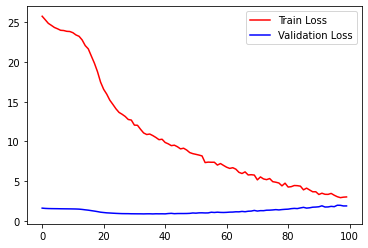

In [77]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list,'r',valid_loss_list , 'b')
plt.legend(["Train Loss", "Validation Loss"], loc ="upper right")
plt.show()

In [78]:
def get_tensor_from_text_test(text,dataset):
    word_list = []
    train_word_to_index_dict = get_word_to_index(dataset['text'])
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word in train_word_to_index_dict.keys()]
    for word in words:
        word_list.append(train_word_to_index_dict[word])
    if len(word_list) > TEXT_LENGTH:
        word_list = word_list[:TEXT_LENGTH]
    else:
        word_list.extend([0]*(TEXT_LENGTH-len(word_list)))
    
    tensor_list = torch.tensor(word_list, device=device, dtype=torch.long)
    return tensor_list

class WeebitTestDataset(torch.utils.data.Dataset):
    def __init__(self,test_dataset,train_dataset):
        self.dataset = test_dataset
        self.train_dataset = train_dataset 
    
    def __getitem__(self,index): 
        text = self.dataset['text'].iloc[index]
        x = get_tensor_from_text_test(text,self.train_dataset)
        y = torch.tensor(self.dataset['readability'].iloc[index],dtype=torch.float,device=device)
        return x,y
    
    def __len__(self):
        return len(self.dataset)


def test(dataset):
  testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1)
  with torch.no_grad():   
    model = torch.load('/content/drive/MyDrive/Readability_Research_Paper/models/3_CNNs/lstm_34.pkl')
    model.eval()
    test_correct = 0
    target_list = []
    output_list = []
    for i, data in enumerate(testloader, 0):
      inputs, targets = data
      # print(targets.item())
      target_list.append(targets.item())
      targets = torch.tensor(targets,dtype=torch.long,device=device)
      outputs = model(inputs)
      output_ids = torch.argmax(outputs, dim=1)
      output_list.append(output_ids.item())
      # outputs = outputs.squeeze(1)
      test_correct += (output_ids == targets).float().sum()

    test_accuracy = 100 * test_correct / len(dataset)
    confusion_matrix_calc = confusion_matrix(target_list,output_list)
    classification_report_calc = classification_report(target_list,output_list)
    return test_accuracy, confusion_matrix_calc, classification_report_calc

In [79]:
weebit_test_dataset = WeebitTestDataset(test_dataset, train_dataset)
accuracy, confusion_matrix_calc, classification_report_calc = test(weebit_test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [80]:
print("Testing accuracy is: " + str(accuracy.item()))
print("\nConfusion Matrix")
print(confusion_matrix_calc)
print("\nClassification Report")
print(classification_report_calc)

Testing accuracy is: 64.20000457763672

Confusion Matrix
[[59 28  8  5  0]
 [32 50 17  1  0]
 [12 36 49  2  1]
 [ 5  3  1 85  6]
 [ 4  0  1 17 78]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.53      0.59      0.56       100
         1.0       0.43      0.50      0.46       100
         2.0       0.64      0.49      0.56       100
         3.0       0.77      0.85      0.81       100
         4.0       0.92      0.78      0.84       100

    accuracy                           0.64       500
   macro avg       0.66      0.64      0.65       500
weighted avg       0.66      0.64      0.65       500

